In [5]:
import pandas as pd
pd.set_option('display.max_rows', None)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix,classification_report

dv = DictVectorizer(sparse = False)

In [8]:
import sklearn
#sklearn.__version__, 
print(sklearn.__version__)

1.5.1


In [11]:
import numpy
print(numpy.__version__)

1.26.4


In [12]:
import pandas as pd
df = pd.read_csv('raw_merged_heart_dataset.csv')
df.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalachh,exang,oldpeak,slope,ca,thal,target
2176,60,1,0,140,207,0,0,138,1,1.9,2,1,3,0
2177,46,1,0,140,311,0,1,120,1,1.8,1,2,3,0
2178,59,1,3,134,204,0,1,162,0,0.8,2,2,2,0
2179,54,1,1,154,232,0,0,164,0,0.0,2,1,2,0
2180,53,1,0,110,335,0,1,143,1,3.0,1,1,3,0


In [15]:
t = df.iloc[2180].to_dict()
t

{'age': 53,
 'sex': 1,
 'cp': 0,
 'trestbps': '110',
 'chol': '335',
 'fbs': '0',
 'restecg': '1',
 'thalachh': '143',
 'exang': '1',
 'oldpeak': 3.0,
 'slope': '1',
 'ca': '1',
 'thal': '3',
 'target': 0}

### DATA CLEANING

In [3]:
'''when I attempted to Vectorize using dictvect, I noticed some numeric were regarded as object. 
so I went back to the kaggle source to confirm the dtypes
I was unable to because dictvecorizer could not convert ?
So I am trying to find and sort the ? issue
'''
columns_with_question_marks = df.columns[df.isin(['?']).any()]

print(columns_with_question_marks)

Index(['trestbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exang', 'slope',
       'ca', 'thal'],
      dtype='object')


In [4]:
df = df.replace('?', np.nan)

In [5]:
# cols_q_mark = ['trestbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exang', 'slope',
#        'ca', 'thal']

# #df[df[cols_q_mark] != '?']

In [6]:
df.isna().sum()

age           0
sex           0
cp            0
trestbps      1
chol         23
fbs           8
restecg       1
thalachh      1
exang         1
oldpeak       0
slope       190
ca          291
thal        266
target        0
dtype: int64

In [7]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps     object
chol         object
fbs          object
restecg      object
thalachh     object
exang        object
oldpeak     float64
slope        object
ca           object
thal         object
target        int64
dtype: object

In [8]:
#Data described from kaggle to be numerical but are objects

source_numericals = ['chol', 'trestbps', 'thalachh', 'oldpeak']

df[source_numericals] = df[source_numericals].apply(pd.to_numeric, errors='coerce').fillna(0)
df.dtypes

age           int64
sex           int64
cp            int64
trestbps    float64
chol        float64
fbs          object
restecg      object
thalachh    float64
exang        object
oldpeak     float64
slope        object
ca           object
thal         object
target        int64
dtype: object

In [9]:
# for the object data types fill missing values with mode

df.isna().sum()

age           0
sex           0
cp            0
trestbps      0
chol          0
fbs           8
restecg       1
thalachh      0
exang         1
oldpeak       0
slope       190
ca          291
thal        266
target        0
dtype: int64

In [10]:
#df['restecg'].value_counts() #mode()#[0]

In [11]:
cat_missing_columns = ['restecg', 'exang', 'slope', 'ca', 'thal']

for col in cat_missing_columns:
    mode_value = df[col].mode()[0]
    df.fillna({col: mode_value}, inplace=True) #or #df[col] = df[col].fillna(mode_value)
    
    

In [12]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         8
restecg     0
thalachh    0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [13]:
df.shape

(2181, 14)

In [14]:
df.describe().round()

,age,sex,cp,trestbps,chol,thalachh,oldpeak,target
count,2181.0,2181.0,2181.0,2181.0,2181.0,2181.0,2181.0,2181.0
mean,53.0,1.0,2.0,132.0,245.0,148.0,1.0,0.0
std,9.0,0.0,1.0,18.0,59.0,24.0,1.0,1.0
min,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,46.0,0.0,0.0,120.0,211.0,132.0,0.0,0.0
50%,54.0,1.0,2.0,130.0,240.0,151.0,1.0,0.0
75%,60.0,1.0,2.0,140.0,276.0,165.0,2.0,1.0
max,77.0,1.0,4.0,200.0,603.0,202.0,6.0,1.0


In [15]:
# Value counts of target
df.target.value_counts()

target
0    1099
1    1082
Name: count, dtype: int64

#### Observation: the classes for risk and less risk are balanced

### DATA PREPARATION (Train val test split)

In [16]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, stratify = df.target, random_state = 42)

df_train, df_val = train_test_split(df, test_size = 0.25, stratify = df.target, random_state = 42)

print(f'The length of training set is {len(df_train)}')
print(f'The length of validation set is {len(df_val)}')
print(f'The length of test set is {len(df_test)}')

The length of training set is 1635
The length of validation set is 546
The length of test set is 437


In [17]:
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [18]:
y_train = df_train.target.values
y_val = df_val.target.values
y_test = df_test.target.values

In [19]:
del df_train['target']
del df_val['target']
del df_test['target']

In [20]:
df_train.shape

(1635, 13)

### TRAINING THE MODEL

#### Decision Tree

In [21]:
#Convert df into a list of dictionaries then conver the list of dict into a feature matrix

train_dict = df_train.to_dict(orient = 'records')

X_train = dv.fit_transform(train_dict)

dv.feature_names_

['age',
 'ca=0',
 'ca=1',
 'ca=2',
 'ca=3',
 'ca=4',
 'chol',
 'cp',
 'exang=0',
 'exang=1',
 'fbs',
 'fbs=0',
 'fbs=1',
 'oldpeak',
 'restecg=0',
 'restecg=1',
 'restecg=2',
 'sex',
 'slope=0',
 'slope=1',
 'slope=2',
 'slope=3',
 'thal=0',
 'thal=1',
 'thal=2',
 'thal=3',
 'thal=6',
 'thal=7',
 'thalachh',
 'trestbps']

In [22]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [23]:
val_dict = df_val.to_dict(orient = 'records')

X_val = dv.transform(val_dict)

y_pred = dt.predict_proba(X_val)[:,1]

In [24]:
print('auc on validation data: ', roc_auc_score(y_pred, y_val))

auc on validation data:  0.9050380572671258


In [25]:
y_pred = dt.predict_proba(X_train)[:,1]

print('auc on validation data: ', roc_auc_score(y_pred, y_train))

auc on validation data:  1.0


##### OBSERVATION: Due to large difference in auc of training and validation data, the model is overfitting

In [26]:
print(export_text(dt, feature_names = dv.feature_names_))

|--- thal=3 <= 0.50
|   |--- thalachh <= 160.50
|   |   |--- cp <= 3.50
|   |   |   |--- sex <= 0.50
|   |   |   |   |--- oldpeak <= 2.70
|   |   |   |   |   |--- age <= 63.50
|   |   |   |   |   |   |--- trestbps <= 146.00
|   |   |   |   |   |   |   |--- fbs=0 <= 0.50
|   |   |   |   |   |   |   |   |--- trestbps <= 134.00
|   |   |   |   |   |   |   |   |   |--- age <= 51.00
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- age >  51.00
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- trestbps >  134.00
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- fbs=0 >  0.50
|   |   |   |   |   |   |   |   |--- cp <= 2.50
|   |   |   |   |   |   |   |   |   |--- age <= 62.50
|   |   |   |   |   |   |   |   |   |   |--- chol <= 80.00
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- chol >  80.00
|   |   |   |   |   |   | 

### FIXING OVERFITTING IN DECISION TREE

In [27]:
for d in range(1, 10):
    dt = DecisionTreeClassifier(max_depth = d)
    dt.fit(X_train, y_train)

    val_pred = dt.predict(X_val)#[:,1]
    train_pred = dt.predict(X_train)
    
    valauc = roc_auc_score(val_pred, y_val).round(3)
    trainauc = roc_auc_score(train_pred, y_train).round(3)
    
    train_pred = dt.predict_proba(X_train)
    print(d, valauc, trainauc)

1 0.679 0.724
2 0.679 0.724
3 0.712 0.764
4 0.751 0.79
5 0.786 0.82
6 0.822 0.877
7 0.853 0.903
8 0.86 0.94
9 0.886 0.962


In [28]:
scores = []

for d in [6,7]:
    for s in [1,2,4,5,15,20,100,200,500]:        
        dt = DecisionTreeClassifier(max_depth = d, min_samples_leaf = s)
        dt.fit(X_train, y_train)
        
        val_pred = dt.predict(X_val)#[:,1]
        train_pred = dt.predict(X_train)
        
        valauc = roc_auc_score(val_pred, y_val).round(3)
        trainauc = roc_auc_score(train_pred, y_train).round(3)

        scores.append((d, s, valauc, trainauc))
        
        # train_pred = dt.predict_proba(X_train)
        # print('(%s, %3d) -> %s %s' % (d, s, valauc, trainauc))

In [29]:
df_scores = pd.DataFrame(scores, columns = ['depth', 'sample_leaf', 'validation_auc', 'training_auc'])
df_scores.sort_values(by = 'validation_auc', ascending = False)

,depth,sample_leaf,validation_auc,training_auc
9,7,1,0.854,0.903
10,7,2,0.854,0.898
11,7,4,0.841,0.892
0,6,1,0.838,0.877
12,7,5,0.833,0.888
3,6,5,0.826,0.868
2,6,4,0.823,0.871
1,6,2,0.822,0.876
13,7,15,0.803,0.845
4,6,15,0.794,0.837


In [30]:
pivot_table = df_scores.pivot(index = 'sample_leaf', columns = 'depth')
pivot_table

validation_auc        training_auc       
depth                    6      7            6      7
sample_leaf                                          
1                    0.838  0.854        0.877  0.903
2                    0.822  0.854        0.876  0.898
4                    0.823  0.841        0.871  0.892
5                    0.826  0.833        0.868  0.888
15                   0.794  0.803        0.837  0.845
20                   0.777  0.793        0.824  0.837
100                  0.722  0.722        0.766  0.766
200                  0.680  0.680        0.754  0.754
500                  0.679  0.679        0.724  0.724

<Axes: xlabel='None-depth', ylabel='sample_leaf'>

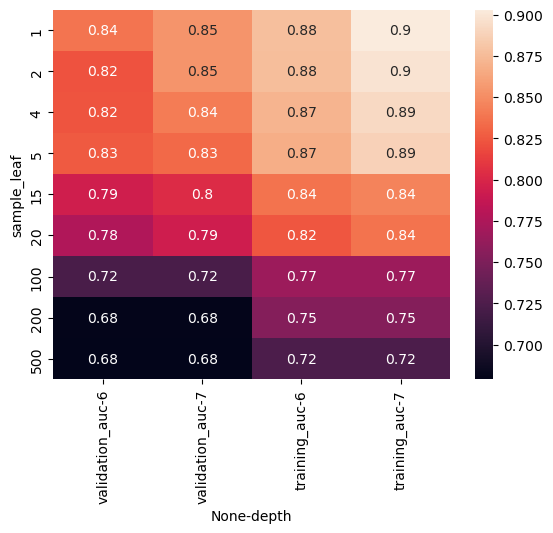

In [31]:
import seaborn as sns

sns.heatmap(pivot_table, annot = True)

#### Final Decision Tree

In [32]:
dt = DecisionTreeClassifier(max_depth = 7, min_samples_leaf = 1)
dt.fit(X_train, y_train)

# val_pred = dt.predict(X_val)#[:,1]

# valauc = roc_auc_score(val_pred, y_val).round(3)
# print(valauc)

DecisionTreeClassifier(max_depth=7)

In [63]:
dt_pred = dt.predict(X_val)

cm = confusion_matrix(y_val, dt_pred)

print(cm)

print(classification_report(y_val, dt_pred))

[[227  48]
 [ 33 238]]
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       275
           1       0.83      0.88      0.85       271

    accuracy                           0.85       546
   macro avg       0.85      0.85      0.85       546
weighted avg       0.85      0.85      0.85       546



### Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
rf = RandomForestClassifier(n_estimators = 7, random_state = 1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=7, random_state=1)

In [35]:
y_pred = rf.predict_proba(X_val)[:,1]
#y_pred

In [36]:
roc_auc_score(y_val, y_pred)

0.9741093592754109

In [37]:
#Train
y_pred = rf.predict_proba(X_train)[:,1]
roc_auc_score(y_train, y_pred)

0.9999132079537428

In [38]:
scores = []

for n in range(5, 20):
    rf = RandomForestClassifier(n_estimators = n, random_state = 1)
    rf.fit(X_train, y_train)
    

    val_pred = rf.predict_proba(X_val)[:,1]
    val_auc = roc_auc_score(y_val, val_pred)

    #Train
    train_pred = rf.predict_proba(X_train)[:,1]
    train_auc = roc_auc_score(y_train, train_pred)

    #print('%s,  %s , %s' % (n, val_auc, train_auc))
    scores.append((n, val_auc, train_auc))

In [39]:
rfscores_df = pd.DataFrame(scores, columns = ['n_estimators', 'val_auc', 'train_auc'])
rfscores_df

,n_estimators,val_auc,train_auc
0,5,0.968024,0.999635
1,6,0.970312,0.999847
2,7,0.974109,0.999913
3,8,0.974780,0.999966
4,9,0.975398,0.999991
5,10,0.973472,0.999993
6,11,0.973311,0.999994
7,12,0.975283,0.999996
8,13,0.975606,0.999985
9,14,0.975726,0.999996


In [40]:
rfscores_df.sort_values(by = 'val_auc', ascending = False)

,n_estimators,val_auc,train_auc
14,19,0.977256,1.000000
10,15,0.976350,0.999991
12,17,0.975995,1.000000
11,16,0.975941,0.999998
13,18,0.975834,1.000000
9,14,0.975726,0.999996
8,13,0.975606,0.999985
4,9,0.975398,0.999991
7,12,0.975283,0.999996
3,8,0.974780,0.999966


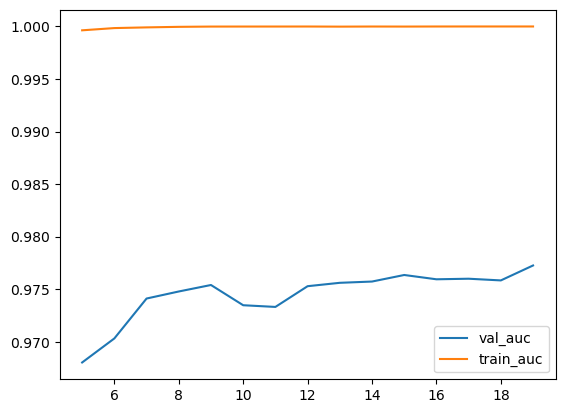

In [41]:
plt.plot(rfscores_df.n_estimators, rfscores_df.val_auc, label = 'val_auc')
plt.plot(rfscores_df.n_estimators, rfscores_df.train_auc, label = 'train_auc')
plt.legend()

In [42]:
scores = []

for d in [5, 10, 15, 20, 25, 30, 35, 40]:
    
    for n in range(5, 20):
        rf = RandomForestClassifier(n_estimators = n, max_depth = d, random_state = 1)
        rf.fit(X_train, y_train)
        
    
        val_pred = rf.predict_proba(X_val)[:,1]
        val_auc = roc_auc_score(y_val, val_pred).round(2)
    
        #Train
        train_pred = rf.predict_proba(X_train)[:,1]
        train_auc = roc_auc_score(y_train, train_pred).round(2)
    
        #print('%s,  %s , %s' % (n, val_auc, train_auc))
        scores.append((d, n, val_auc, train_auc))

In [43]:
rfscores_df = pd.DataFrame(scores, columns = ['max_depth','n_estimators', 'val_auc', 'train_auc'])
rfscores_df.sort_values(by = 'val_auc', ascending = False).head()

,max_depth,n_estimators,val_auc,train_auc
119,40,19,0.98,1.0
36,15,11,0.98,1.0
53,20,13,0.98,1.0
52,20,12,0.98,1.0
84,30,14,0.98,1.0


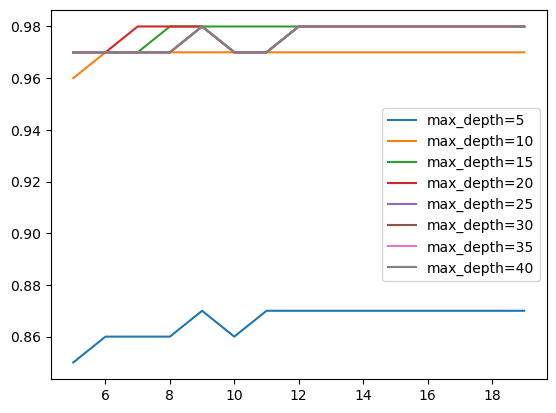

In [44]:
for d in [5, 10, 15, 20, 25, 30, 35, 40]:
    df_subset = rfscores_df[rfscores_df.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.val_auc, label = 'max_depth=%d' % d)
plt.legend()

##### OBSERVATION: From max_Depth of 15, the validation accuracy does not increase by going higher

In [45]:
scores = []

for s in [3, 5, 100, 200]:
    
    for n in range(5, 20):
        rf = RandomForestClassifier(n_estimators = n, 
                                    max_depth = 15,
                                    min_samples_leaf = s,
                                    random_state = 1)
        rf.fit(X_train, y_train)
        
    
        val_pred = rf.predict_proba(X_val)[:,1]
        val_auc = roc_auc_score(y_val, val_pred).round(2)
    
        #Train
        train_pred = rf.predict_proba(X_train)[:,1]
        train_auc = roc_auc_score(y_train, train_pred).round(2)
    
        #print('%s,  %s , %s' % (n, val_auc, train_auc))
        scores.append((s, n, val_auc, train_auc))

In [46]:
rfscores_df = pd.DataFrame(scores, columns = ['leaf','n_estimators', 'val_auc', 'train_auc'])
rfscores_df.sort_values(by = 'val_auc', ascending = False).head()

,leaf,n_estimators,val_auc,train_auc
11,3,16,0.96,1.00
10,3,15,0.96,1.00
2,3,7,0.96,0.99
3,3,8,0.96,0.99
14,3,19,0.96,1.00


##### OBSERVATION: Adding min_samples_leaf parameter generally decreases the accuracy of the validation data

##### OBSERVTION: Best random forest is obtained when number of estimators is 11 and max depth is 15

In [47]:
scores = []

for f in [10, 15, 20]:
    
    for n in range(5, 20):
        rf = RandomForestClassifier(n_estimators = n, 
                                    max_depth = 15,
                                    max_features = f,
                                    bootstrap = False,
                                    random_state = 1)
        rf.fit(X_train, y_train)
        
    
        val_pred = rf.predict_proba(X_val)[:,1]
        val_auc = roc_auc_score(y_val, val_pred).round(2)
    
        #Train
        train_pred = rf.predict_proba(X_train)[:,1]
        train_auc = roc_auc_score(y_train, train_pred).round(2)
    
        #print('%s,  %s , %s' % (n, val_auc, train_auc))
        scores.append((f, n, val_auc, train_auc))

In [48]:
rfscores_df = pd.DataFrame(scores, columns = ['max_features','n_estimators', 'val_auc', 'train_auc'])
rfscores_df.sort_values(by = 'val_auc', ascending = False).head()

,max_features,n_estimators,val_auc,train_auc
44,20,19,0.98,1.0
40,20,15,0.98,1.0
29,15,19,0.98,1.0
28,15,18,0.98,1.0
27,15,17,0.98,1.0


##### OBSERVATION: Max number of features does not make a difference

### Final Random Forest

In [49]:
rf = RandomForestClassifier(n_estimators = 11, 
                                    max_depth = 15,
                                    random_state = 1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=11, random_state=1)

In [61]:
rf_pred = rf.predict(X_val)

cm = confusion_matrix(y_val, rf_pred)

print(cm)

print(classification_report(y_val, rf_pred))

[[244  31]
 [ 17 254]]
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       275
           1       0.89      0.94      0.91       271

    accuracy                           0.91       546
   macro avg       0.91      0.91      0.91       546
weighted avg       0.91      0.91      0.91       546



### XGBOOST

In [50]:
import xgboost as xgb

In [51]:
#Create an xgb matrix for training set

features = dv.feature_names_
dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = features)
dval = xgb.DMatrix(X_val, label = y_val, feature_names = features)

In [52]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [53]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'eval_metric':'auc',
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, evals = watchlist, num_boost_round = 200)

[0]	train-auc:0.93712	val-auc:0.87501
[1]	train-auc:0.96587	val-auc:0.90549
[2]	train-auc:0.97506	val-auc:0.92035
[3]	train-auc:0.98002	val-auc:0.92704
[4]	train-auc:0.98567	val-auc:0.93408
[5]	train-auc:0.98862	val-auc:0.93837
[6]	train-auc:0.99013	val-auc:0.94029
[7]	train-auc:0.99177	val-auc:0.94114
[8]	train-auc:0.99260	val-auc:0.94272
[9]	train-auc:0.99517	val-auc:0.94731
[10]	train-auc:0.99579	val-auc:0.94743
[11]	train-auc:0.99685	val-auc:0.94794
[12]	train-auc:0.99737	val-auc:0.94747
[13]	train-auc:0.99800	val-auc:0.94652
[14]	train-auc:0.99841	val-auc:0.94867
[15]	train-auc:0.99877	val-auc:0.95189
[16]	train-auc:0.99901	val-auc:0.95226
[17]	train-auc:0.99914	val-auc:0.95302
[18]	train-auc:0.99930	val-auc:0.95269
[19]	train-auc:0.99936	val-auc:0.95265
[20]	train-auc:0.99952	val-auc:0.95363
[21]	train-auc:0.99959	val-auc:0.95326
[22]	train-auc:0.99962	val-auc:0.95371
[23]	train-auc:0.99964	val-auc:0.95450
[24]	train-auc:0.99970	val-auc:0.95467
[25]	train-auc:0.99974	val-auc:0.95

In [54]:
y_pred = model.predict(dval)
auc = roc_auc_score(y_val, y_pred)
auc

0.9632874874203288

In [55]:
y_pred = model.predict(dtrain)
auc = roc_auc_score(y_train, y_pred)
auc

1.0

In [56]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    'eval_metric':'auc',
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, evals = watchlist, num_boost_round = 200)

[0]	train-auc:0.93712	val-auc:0.87501
[1]	train-auc:0.96151	val-auc:0.89813
[2]	train-auc:0.96573	val-auc:0.90460
[3]	train-auc:0.96662	val-auc:0.90478
[4]	train-auc:0.96896	val-auc:0.90605
[5]	train-auc:0.97162	val-auc:0.90623
[6]	train-auc:0.97174	val-auc:0.90862
[7]	train-auc:0.97688	val-auc:0.91446
[8]	train-auc:0.97796	val-auc:0.91669
[9]	train-auc:0.97905	val-auc:0.91845
[10]	train-auc:0.97998	val-auc:0.91969
[11]	train-auc:0.98185	val-auc:0.92219
[12]	train-auc:0.98291	val-auc:0.92187
[13]	train-auc:0.98474	val-auc:0.92631
[14]	train-auc:0.98500	val-auc:0.92707
[15]	train-auc:0.98561	val-auc:0.92813
[16]	train-auc:0.98651	val-auc:0.93017
[17]	train-auc:0.98774	val-auc:0.93304
[18]	train-auc:0.98834	val-auc:0.93433
[19]	train-auc:0.98907	val-auc:0.93650
[20]	train-auc:0.99006	val-auc:0.93691
[21]	train-auc:0.99064	val-auc:0.93848
[22]	train-auc:0.99118	val-auc:0.93981
[23]	train-auc:0.99178	val-auc:0.93995
[24]	train-auc:0.99262	val-auc:0.94172
[25]	train-auc:0.99335	val-auc:0.94

In [57]:
y_pred = model.predict(dval)
auc = roc_auc_score(y_val, y_pred)
auc

0.9680107346528011

In [58]:
y_pred = model.predict(dtrain)
auc = roc_auc_score(y_train, y_pred)
auc

1.0

### SAVING THE BEST MODEL (RANDOM FOREST)

In [65]:
import pickle

In [66]:
def train(df_train, y_train):
    traindict = df_train.to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(traindict)
    
    model = RandomForestClassifier(n_estimators = 11, 
                                    max_depth = 15,
                                    random_state = 1)
    model.fit(X_train, y_train)

    return dv, model

In [70]:
def predict(df, dv, model):
    dicts = df.to_dict(orient = 'records')

    X_pred = dv.transform(dicts)

    pred = model.predict(X_pred)

    return pred

In [67]:
dv, model = train(df_train, y_train)

In [69]:
#model.predict(X_val)

In [1]:
output_file = 'model_rf_est11_depth15.bin'

In [73]:
with open(output_file, 'wb') as f_out:
    pickle.dump((dv, model), f_out)

In [2]:
import pickle

In [3]:
with open(output_file, 'rb') as f_in:
    dv, model = pickle.load( f_in)

In [4]:
dv, model

(DictVectorizer(sparse=False),
 RandomForestClassifier(max_depth=15, n_estimators=11, random_state=1))

In [21]:
patient = df.iloc[3].to_dict()
patient

{'age': 56,
 'sex': 1,
 'cp': 1,
 'trestbps': '120',
 'chol': '236',
 'fbs': '0',
 'restecg': '1',
 'thalachh': '178',
 'exang': '0',
 'oldpeak': 0.8,
 'slope': '2',
 'ca': '0',
 'thal': '2',
 'target': 1}

In [22]:
patient = {'age': 56,
 'sex': 1,
 'cp': 1,
 'trestbps': '120',
 'chol': '236',
 'fbs': '0',
 'restecg': '1',
 'thalachh': '178',
 'exang': '0',
 'oldpeak': 0.8,
 'slope': '2',
 'ca': '0',
 'thal': '2',
  }

In [23]:
x = dv.transform([patient])

x

array([[56. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  1. ,  0. ,  0. ,
         1. ,  0. ,  0.8,  0. ,  1. ,  0. ,  1. ,  0. ,  0. ,  1. ,  0. ,
         0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ]])

In [24]:
model.predict(x)

array([1], dtype=int64)